# Plots for Paper

Here we summarize the most relevant results achieved during the project. We provide teh code and the plot in order to be as clear as possible.

In [3]:
from typing import Optional, List, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

from src.utils.utils import plot_hist, block_mean, block_std, get_energy
from src.utils.pltutils import plt_eng_step, plt_acf, plt_betas_ar
from src.utils.montecarlo import neural_mcmc, hybrid_mcmc, seq_hybrid_mcmc, single_spin_flip

## Correlation and thermalization

We focused on the system with 484 spins and 1NN couplings, in this scenario we observe a significative boosting when using the neural network inside the Monte Carlo methods as a smart proposal.
We called this  procedure *Neural Markov Chain Monte Carlo (Neural MCMC)*. In this method the Metropolis-Hastings acceptance rate becomes
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')\omega_{\mathbf{\sigma}\mathbf{\sigma}'}}{p(\mathbf{\sigma})\omega_{\mathbf{\sigma}'\mathbf{\sigma}}}\right).
$$

Then we compare with the data generated by the neural network, an autoregressive model called **MADE** (**M**asked **A**utoregressive **D**ensity **E**stimator), in this case. Since our goal is to use [D-Wave](https://www.dwavesys.com/) dataset we need to understand at which temperature, let's say *effective* $\beta$ (we indicate it as $\beta_{eff}$), the dataset are more efficient.

In the following, we compare some dataset, including a classic one obtained by a Markov Chain Monte Carlo with single spin moves, used as a benchmark.

In [6]:
datasets = [
        "data/generated/sample-1000000_size-484_2022-01-28_15-48-44.npz", # 1mus 1nn
        "data/generated/sample-1000000_size-484_2022-01-28_15-50-01.npz", # 10mus 1nn
        "data/generated/sample-1000000_size-484_2022-02-10_11-48-45.npz", # 100mus 1nn
        "data/generated/sample-1000000_size-484_2022-05-10_23-59-33.npz", # 1-10-100mus 1nn
        "data/generated/sample-1000000_size-484_2022-02-10_15-28-37.npz", # 1<beta<2.5 1nn
        "data/generated/sample-1000000_size-484_2022-02-10_17-00-33.npz" # 100mus and 1<beta<2.5 1nn
        ]

labels = [r"1 $\mu$s",r"10 $\mu$s", r"100 $\mu$s", r"1-10-100 $\mu$s", 
          r"$1\leq\beta\leq2.5$", r"$100 \mu$s and $1\leq\beta\leq2.5$"
        ]

betas = np.linspace(0.5, 4, num=36)
couplings_path = "data/couplings/484spins-uniform-1nn.txt"
ground_state = -0.755

In [8]:
acc_rates = []
for i, dataset in enumerate(datasets):
    acc_rate = []
    if i == 3 or i ==4:
        continue
    for beta in betas:
        _, eng_neural, ar = neural_mcmc(beta, 10000, dataset, couplings_path, "made", disable_bar=True)
        acc_rate.append(ar)
    acc_rates.append(acc_rate)


Performing Neural MCMC at beta=0.5
Steps:  10000 A_r=0.11%
E=-0.655446 ± 0.000048  [σ=0.004794  E_min=-0.706512]
Duration 0:00:00.821371

Performing Neural MCMC at beta=0.6
Steps:  10000 A_r=0.14%
E=-0.658301 ± 0.000086  [σ=0.008587  E_min=-0.706512]
Duration 0:00:00.806658

Performing Neural MCMC at beta=0.7
Steps:  10000 A_r=0.12%
E=-0.655462 ± 0.000048  [σ=0.004815  E_min=-0.706512]
Duration 0:00:00.808380

Performing Neural MCMC at beta=0.8
Steps:  10000 A_r=0.14%
E=-0.655491 ± 0.000047  [σ=0.004746  E_min=-0.702782]
Duration 0:00:00.807211

Performing Neural MCMC at beta=0.9
Steps:  10000 A_r=0.14%
E=-0.658474 ± 0.000088  [σ=0.008757  E_min=-0.706512]
Duration 0:00:00.809529

Performing Neural MCMC at beta=1.0
Steps:  10000 A_r=0.16%
E=-0.662333 ± 0.000109  [σ=0.010888  E_min=-0.706512]
Duration 0:00:00.824795

Performing Neural MCMC at beta=1.1
Steps:  10000 A_r=0.18%
E=-0.658724 ± 0.000092  [σ=0.009198  E_min=-0.706512]
Duration 0:00:00.816758

Performing Neural MCMC at beta=1.

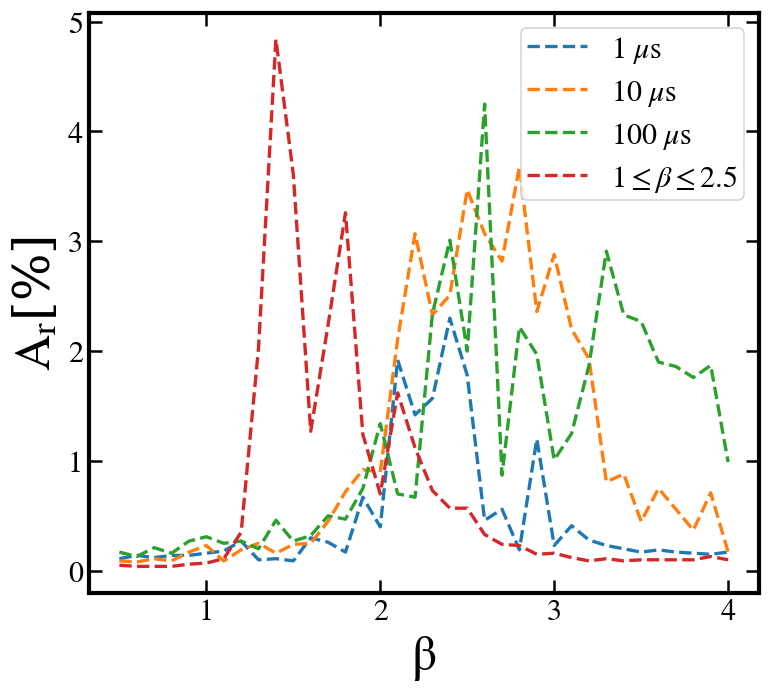

In [9]:
# remove the labels of the dataset  
# that we didn't use
labels_ar = []
for i, label in enumerate(labels):
    if i==3 or i==4:
        continue
    labels_ar.append(label)

plt_betas_ar(acc_rates, labels_ar, betas)

From the plot above, it seems that the dataset obtain with an annealing time = $100\mu s$ has a better $A_r$ at every temperatures, especially at low temperatures (high $\beta$).

So we collect some Single Spin Flip MCMC at $\beta=3.0$, starting from differet initial configuration, in order to show the performace of the Neural approach. 

In [9]:
spin_side = 22
spins = spin_side**2
beta = 3

seeds = [2353415, 5983276, 587346, 34789] # seed for starting point of mcmc simulations
steps=10000000 # perform a quite long run

In [20]:
engs_single=[]
for seed in seeds:
    engs_single.append(single_spin_flip(spins, beta, steps, couplings_path, sweeps=0, seed=seed, disable_bar=True)[1])
engs_single = np.asarray(engs_single) / spins


Start MCMC simulation
beta=3 seed=2353415

MCMC: Beta=3 Seed=2353415
Steps: 10000000  A_r=5.13%  E=-0.728028 ± 0.000003  [σ=0.008430  E_min=-0.748082]
Duration 0:02:00.921947

Start MCMC simulation
beta=3 seed=5983276

MCMC: Beta=3 Seed=5983276
Steps: 10000000  A_r=5.11%  E=-0.725171 ± 0.000003  [σ=0.008106  E_min=-0.744684]
Duration 0:01:51.420510

Start MCMC simulation
beta=3 seed=587346

MCMC: Beta=3 Seed=587346
Steps: 10000000  A_r=5.01%  E=-0.727982 ± 0.000003  [σ=0.008797  E_min=-0.748169]
Duration 0:01:51.786901


In [89]:
_, eng_neural, ar = neural_mcmc(beta, 1000000, datasets[2], couplings_path, "made", disable_bar=True)
eng_neural = eng_neural / spins


Performing Neural MCMC at beta=3
Steps: 1000000 A_r=0.96%
E=-0.729539 ± 0.000004  [σ=0.004442  E_min=-0.752436]
Duration 0:00:22.883029


First of all, we plot the energy w.r.t the steps of the Markov Chain. For the Single Spin Flip simulations we plot the mean of 5 chains and the shadow of the minimum and the maximum value. 

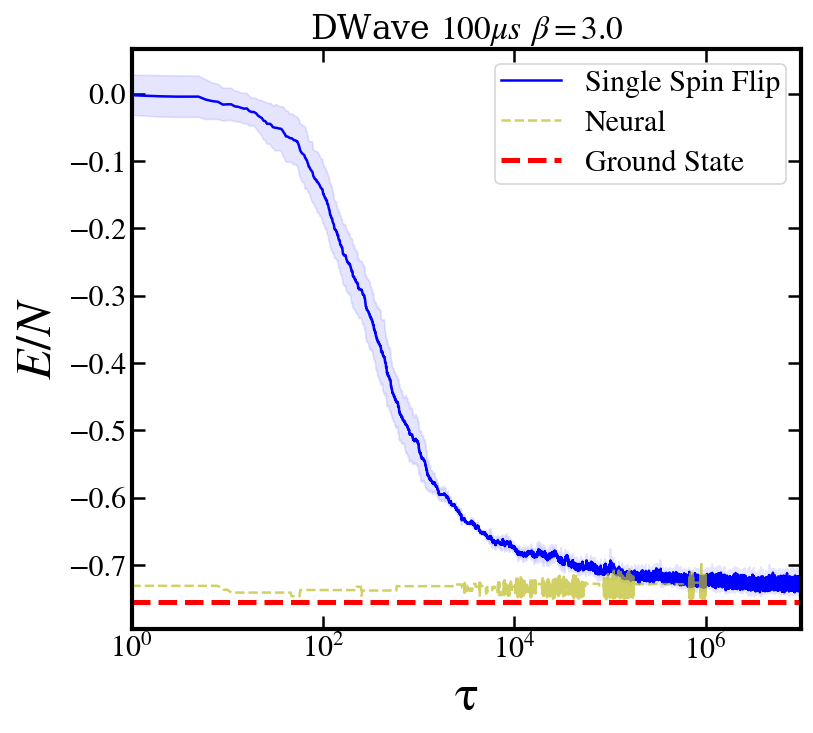

In [92]:
plt_eng_step(engs_single, eng_neural, "Single Spin Flip", "Neural", ground_state=ground_state, xlim=(1,10000000),
            title=r"DWave $100 \mu s$ $\beta=3.0$",
            )

Moreover, we can compute the autocorrelation function, after removing the first sample for thermalization. The following plot in log scale shows that the autocorrelation lenght decays at least $10^2$ times faster in the neural than in the single spin flip simulation. The two simulation are run for $4 \cdot 10^5$ and $10^6$ steps, for the neural and the single spin flip. The plot is log scale and the shadow is the $\sigma$ obtained from 5 different simulations (only for single spin flip).
Autocorrelation is computed by
$$
c(\tau) = \frac{\langle H(t+\tau)H(t) \rangle - \langle H(t) \rangle^2}{\langle H(t)H(t) \rangle - \langle H(t) \rangle^2}
$$

In [93]:
skip=8000000

acs = []
for i in range(len(engs_single)):
    acs.append(acf(engs_single[i][skip:], nlags=engs_single[0].shape[0] - skip, fft=True))
ac_neural = acf(eng_neural, nlags=eng_neural.shape[0], fft=True)
acs = np.asarray(acs)

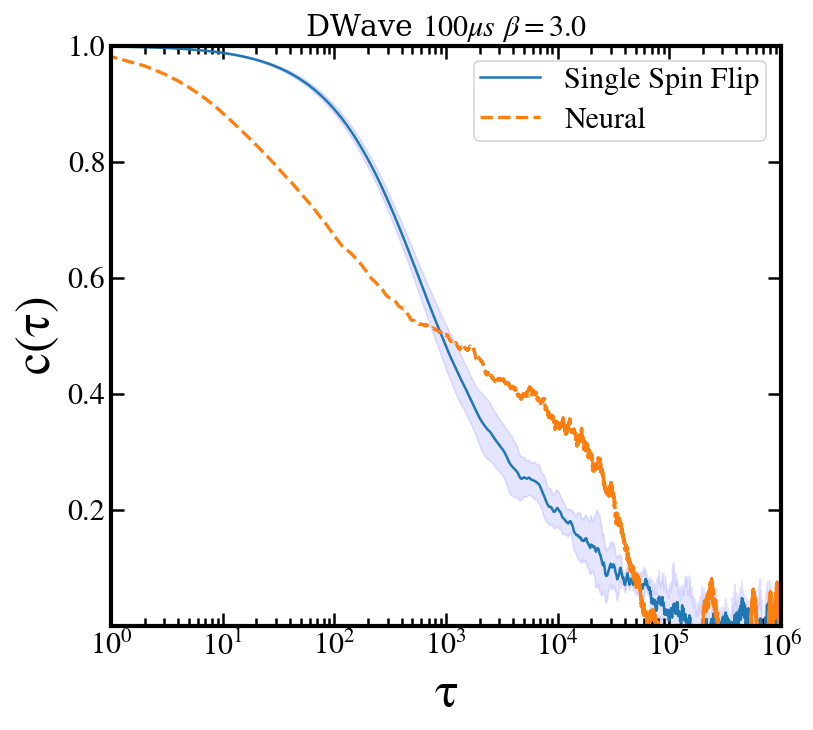

In [94]:
plt_acf(acs, "Single Spin Flip", ac_neural, "Neural", xlim=(1,1000000), ylim=(0.0001, 1), title=r"DWave $100 \mu s$ $\beta=3.0$")

Morevoer, different $\beta$ lead to different autocorrelation lengths. In the following we give a visual representation of it.

In [26]:
betas = np.linspace(1., 2.5, num=16) # length step 0.5
steps= 100000
skip=900

In [27]:
betas_eng_single = []
betas_sample_single = []
for b in betas:
    sample, eng = single_spin_flip(spins, b, steps, couplings_path, sweeps=1, disable_bar=False)
    betas_sample_single.append(sample)
    betas_eng_single.append(eng)
betas_sample_single = np.asarray(betas_sample_single)
betas_eng_single = np.asarray(betas_eng_single) / spins


Start MCMC simulation
beta=1.0 seed=42


eng: -0.48939:  20%|██        | 10046/50000 [00:40<02:40, 248.37it/s]


KeyboardInterrupt: 

In [17]:
ac_betas = []
for i in range(len(betas_eng_single)):
    ac_betas.append(acf(betas_eng_single[i][skip:], nlags=betas_eng_single[0].shape[0], fft=True))

Here we plot some autocorrelation functions, using log representation long the $y$ axis. Moreover, we fit these autocerrelations with a stretch exponential function
$$ 
c(\tau) = a\exp(\left[-(\tau/\tau^*)^\alpha\right]).
$$
We print the empirical-fitted parameters below with the plot af outocorrelation from $\beta=0.5$ to $\beta=3.5$. As one can see, $\tau^*$ quickly diverges and starting from $\beta \geq 3.0$ we find $\tau^* \simeq 1000$.

$\beta=2.0$ a=2.0607250290110253 tau*=199.26531438441356 alpha=0.19355883835408666
$\beta=2.5$ a=1.7901522901868232 tau*=446.7060590364041 alpha=0.20876614785118544
$\beta=3.0$ a=1.796493160898931 tau*=3260.3506381877714 alpha=0.09143732784666861


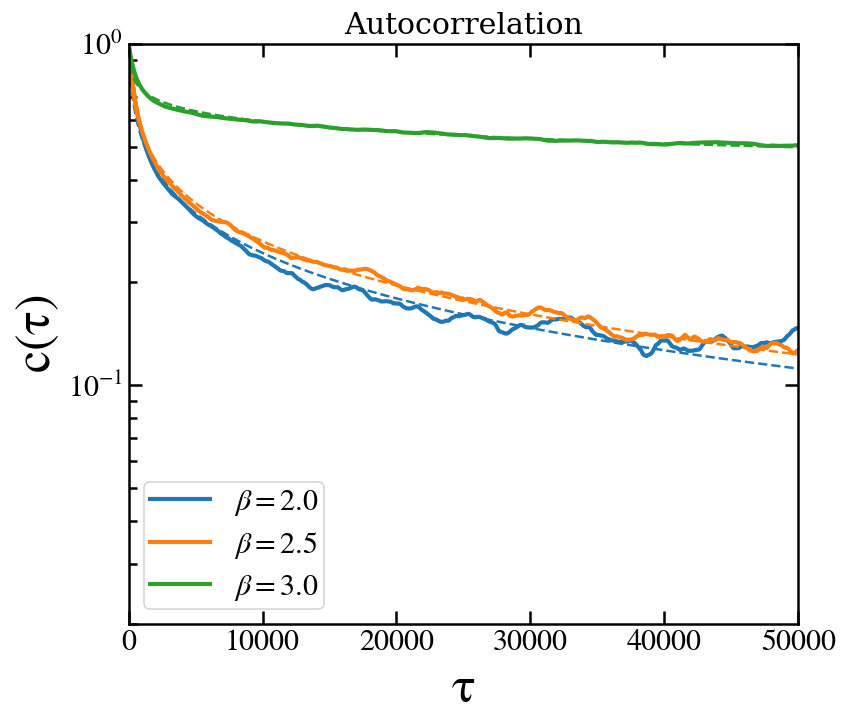

In [19]:
label1 = [rf"$\beta={beta}$" for beta in betas]

plt_acf(ac_betas, label1, title=r"Autocorrelation", log_scale=False, xlim=(0, 50000), ylim=(0.02, 1), fit=True)

In [13]:
def plt_eng_step(
    eng1: np.ndarray,
    eng2: np.ndarray,
    label1: str,
    label2: str,
    ground_state: Optional[float] = None,
    xlim: Optional[Tuple[int, int]] = (1, 1000000),
    title: Optional[str] = None,
    log_scale: bool = True,
    save: bool = False,
):
    fig, ax = plt.subplots(figsize=(7.2, 6.4), dpi=120)

    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["axes.linewidth"] = 2.5

    stringfont = "serif"

    ax.tick_params(
        axis="y",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=1.5,
        length=8,
        direction="in",
        labelsize=18,
    )
    ax.tick_params(
        axis="x",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=1.5,
        length=8,
        direction="in",
        labelsize=18,
    )
    ax.tick_params(
        which="minor",
        top=True,
        right=False,
        labeltop=False,
        labelright=False,
        width=1.5,
        length=5,
        direction="in",
        labelsize=18,
    )
    if len(eng1.shape) > 1: 
        plt.fill_between(
            np.arange(eng1.shape[-1]),
            eng1.mean(axis=0) + eng1.std(axis=0),
            eng1.mean(axis=0) - eng1.std(axis=0),
            alpha=0.1,
            color="b",
        )
        plt.plot(eng1.mean(axis=0), label=label1, color="b", linewidth=1.5)
    else:
        plt.plot(eng1, label=label1, color="b", linewidth=1.5)

    plt.plot(eng2, "--", label=label2, color="tab:olive", alpha=0.7)

    if log_scale:
        ax.set_xscale("log")

    if ground_state is not None:
        plt.hlines(
            ground_state,
            xmin=0,
            xmax=xlim[1] + 100000,
            colors="red",
            linestyles="dashed",
            label="Ground State",
            linewidth=3.0,
        )
    if xlim is not None:
        plt.xlim(xlim)

    plt.ylabel(r"$E/N$", fontsize=30, fontfamily=stringfont, fontweight="bold")
    plt.xlabel(
        r"$\mathrm{\tau}$", fontsize=30, fontfamily=stringfont, fontweight="bold"
    )

    if title is not None:
        plt.title(rf"{title}", fontsize=20, fontfamily=stringfont)

    plt.legend(loc="best", fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)
    plt.show()

    if save:
        plt.savefig(
            "images/energy-steps.png",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            bbox_inches="tight",
            transparent=False,
        )


In [14]:
from scipy.optimize import curve_fit


def plt_acf(
    acs1: Union[np.ndarray, List[np.ndarray]],
    label1: Union[str, List[str]],
    acs2: Optional[np.ndarray] = None,
    label2: Optional[str] = None,
    xlim: Tuple[int, int] = (1, 1000000),
    ylim: Tuple[int, int] = (0.01, 1),
    title: Optional[str] = None,
    fit: bool = False,
    log_scale: bool = True,
    save: bool = False,
):
    fig, ax = plt.subplots(figsize=(7.2, 6.4), dpi=120)

    def stretch_exp(t, a, tau, alpha):
        return a * np.exp(-((t / tau) ** alpha))

    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["axes.linewidth"] = 2.5

    stringfont = "serif"

    ax.tick_params(
        axis="y",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=1.5,
        length=8,
        direction="in",
        labelsize=18,
    )
    ax.tick_params(
        axis="x",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=1.5,
        length=8,
        direction="in",
        labelsize=18,
    )
    ax.tick_params(
        which="minor",
        top=True,
        right=False,
        labeltop=False,
        labelright=False,
        width=1.5,
        length=5,
        direction="in",
        labelsize=18,
    )

    plt.rcParams["axes.linewidth"] = 1.5

    if isinstance(acs1, list):
        assert len(acs1) == len(label1)

        for i, acs in enumerate(acs1):
            color = next(ax._get_lines.prop_cycler)["color"]
            plt.plot(acs, label=label1[i], linewidth=2.5, color=color)
            ax.set_yscale("log")
            if fit:
                p, _ = curve_fit(
                    stretch_exp,
                    np.arange(xlim[1]),
                    acs[: xlim[1]],
                    bounds=([-np.inf, 0, 0], [np.inf, np.inf, np.inf]),
                )
                print(f"{label1[i]} a={p[0]} tau*={p[1]} alpha={p[2]}")
                plt.plot(
                    stretch_exp(np.arange(xlim[1]), p[0], p[1], p[2]),
                    "--",
                    color=color,
                )
    else:
        plt.plot(acs1.mean(0), label=label1, linewidth=1.5)
        plt.fill_between(
            np.arange(acs1.shape[1]),
            acs1.mean(0) + acs1.std(0),
            acs1.mean(0) - acs1.std(0),
            alpha=0.1,
            color="b",
        )

    if acs2 is not None:
        plt.plot(acs2, "--", label=label2, linewidth=2.0)

    if log_scale:
        ax.set_xscale("log")

    plt.ylabel(
        r"$\mathrm{c(\tau)}$", fontsize=30, fontfamily=stringfont, fontweight="bold"
    )
    plt.xlabel(
        r"$\mathrm{\tau}$", fontsize=30, fontfamily=stringfont, fontweight="bold"
    )

    plt.ylim(ylim)
    plt.xlim(xlim)

    plt.title(title, fontsize=18, fontfamily=stringfont)

    plt.legend(loc="best", fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)
    plt.show()

    if save:
        plt.savefig(
            "images/correlation.png",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            bbox_inches="tight",
            transparent=False,
        )



Performing Neural MCMC at beta=1.0
Steps: 100000 A_r=0.06%
E=-0.702428 ± 0.000017  [σ=0.005286  E_min=-0.736815]
Duration 0:00:03.110396


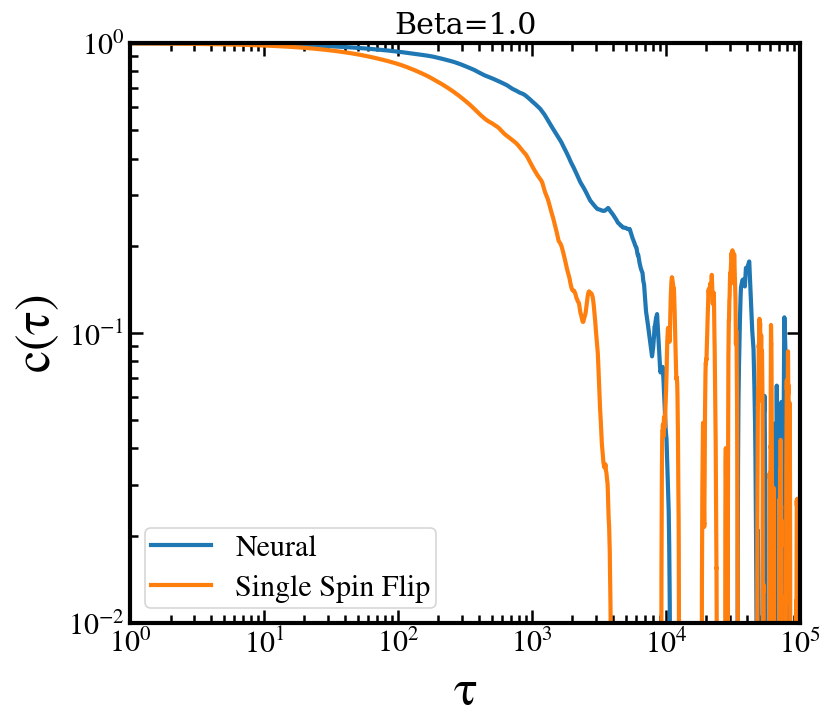

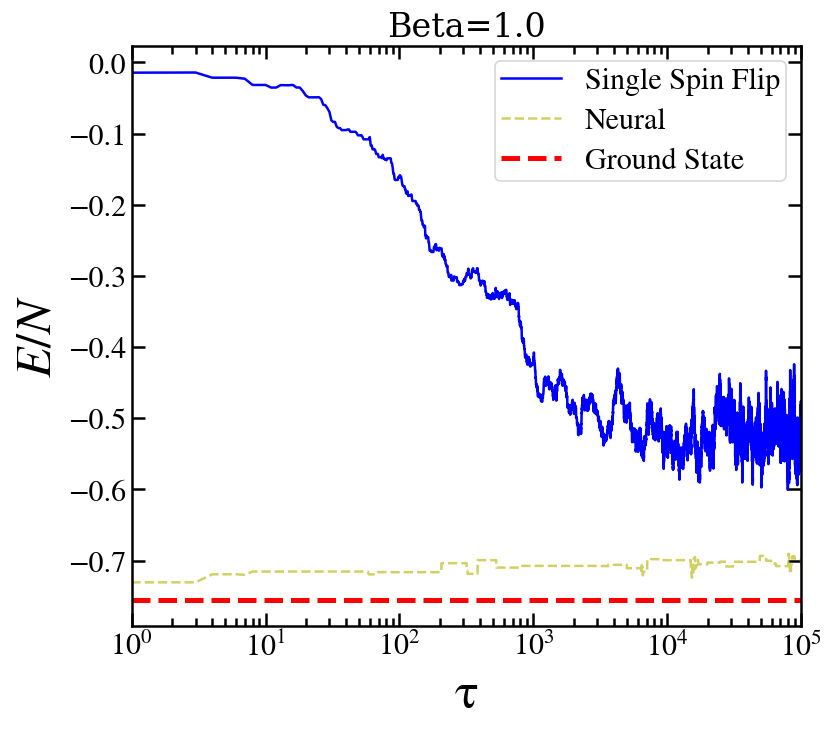


Performing Neural MCMC at beta=1.1
Steps: 100000 A_r=0.03%
E=-0.704231 ± 0.000013  [σ=0.004178  E_min=-0.736815]
Duration 0:00:03.215971


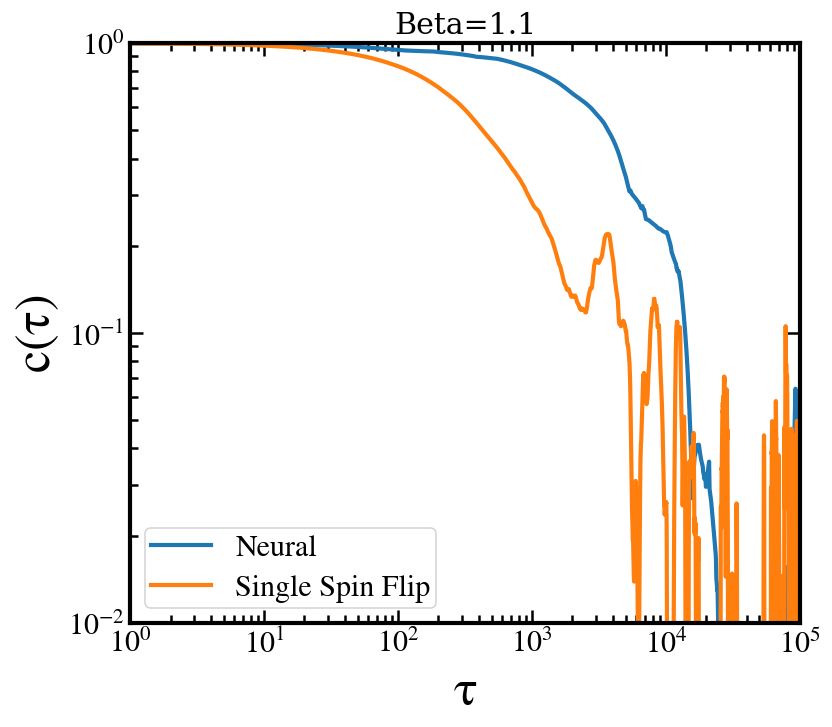

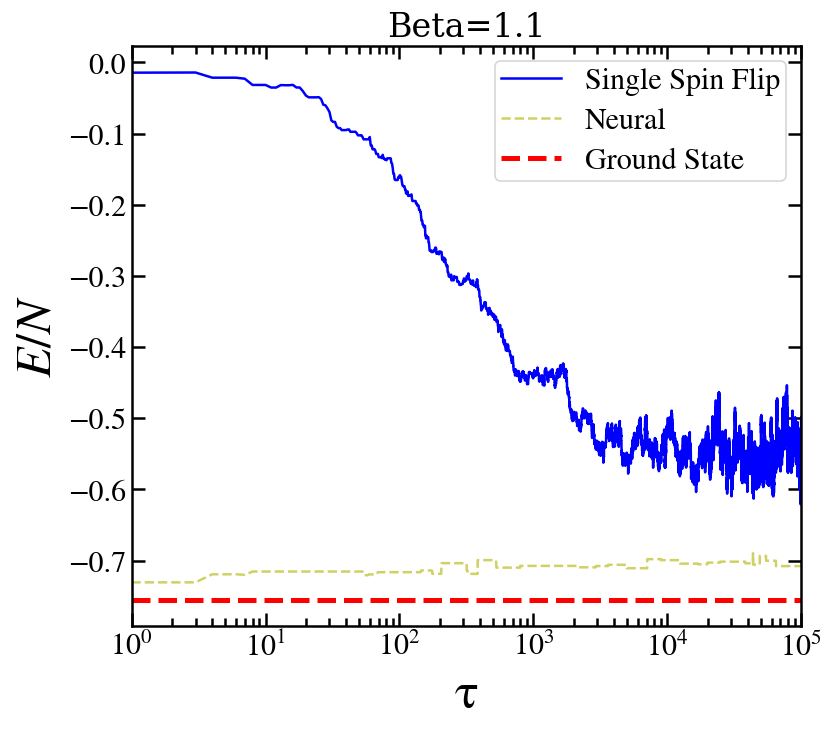


Performing Neural MCMC at beta=1.2
Steps: 100000 A_r=0.04%
E=-0.703185 ± 0.000014  [σ=0.004553  E_min=-0.736815]
Duration 0:00:03.175329


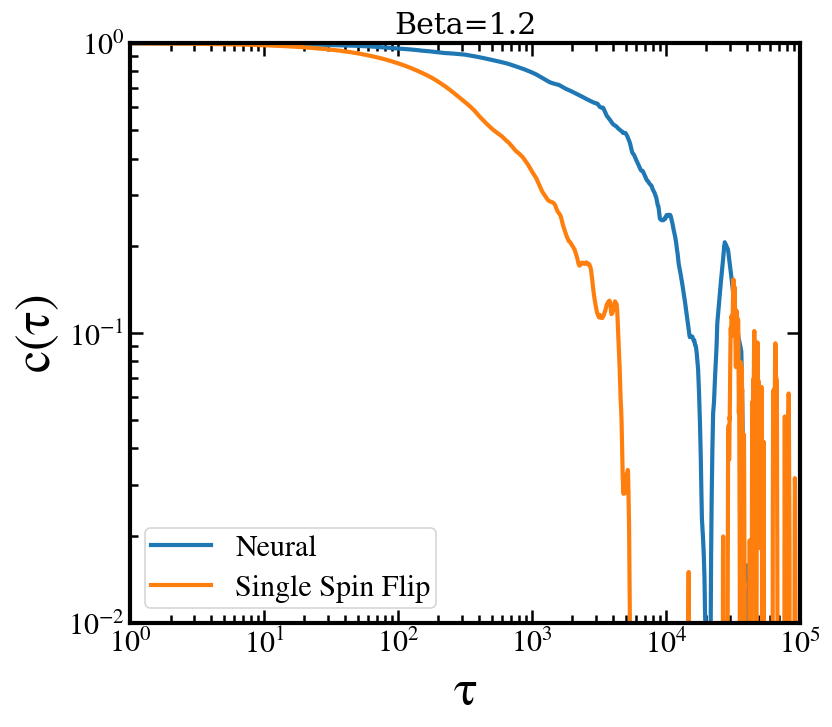

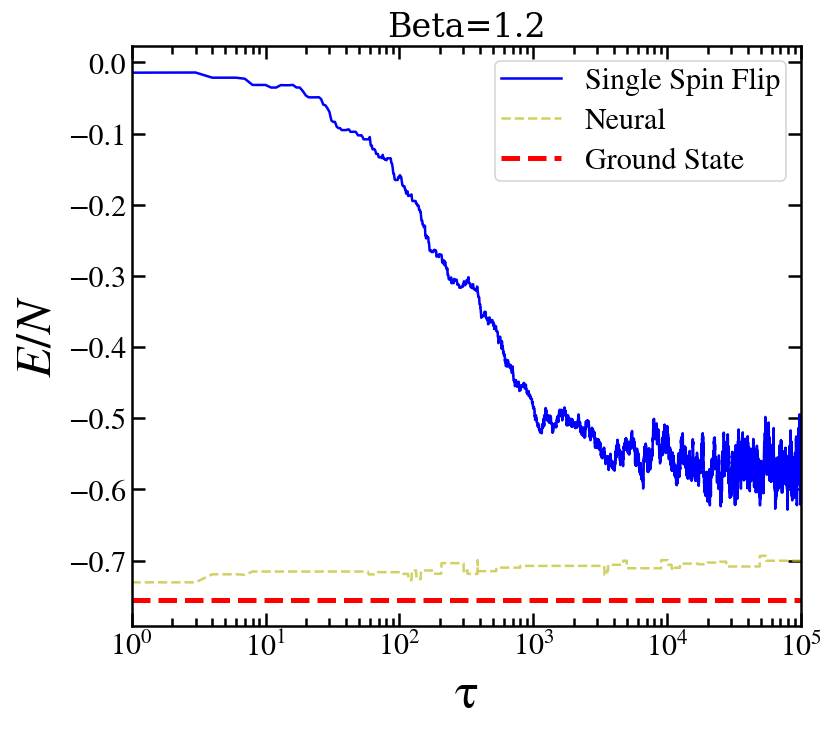


Performing Neural MCMC at beta=1.3
Steps: 100000 A_r=0.08%
E=-0.702464 ± 0.000015  [σ=0.004733  E_min=-0.736815]
Duration 0:00:03.761847


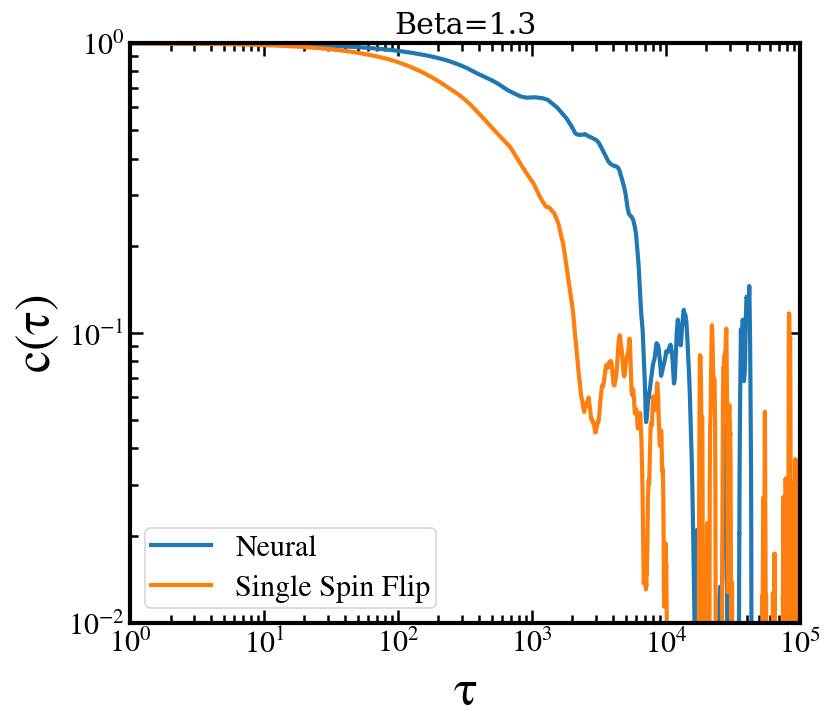

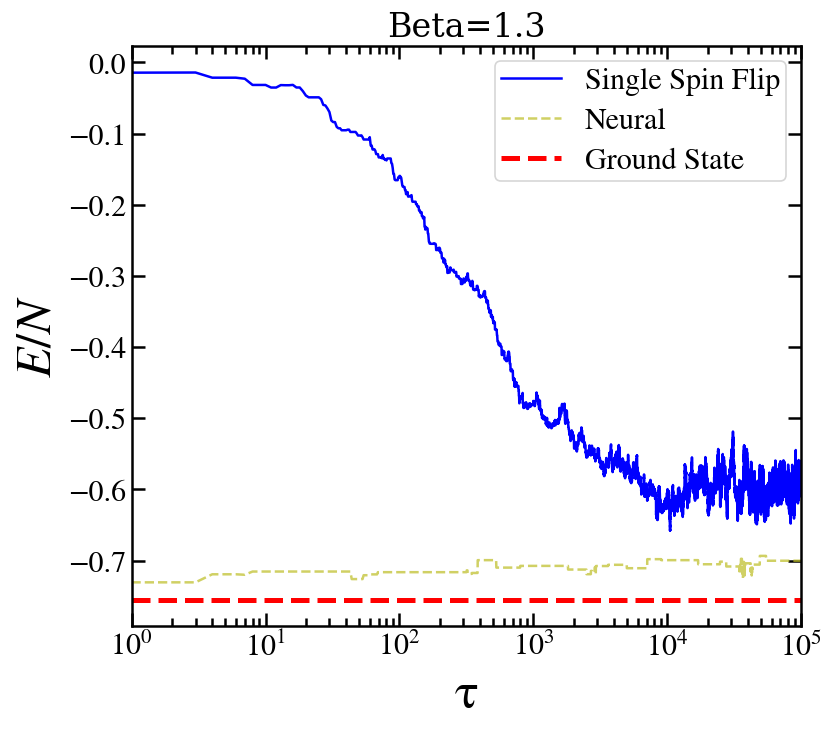


Performing Neural MCMC at beta=1.4
Steps: 100000 A_r=0.07%
E=-0.707498 ± 0.000019  [σ=0.006101  E_min=-0.736815]
Duration 0:00:03.545486


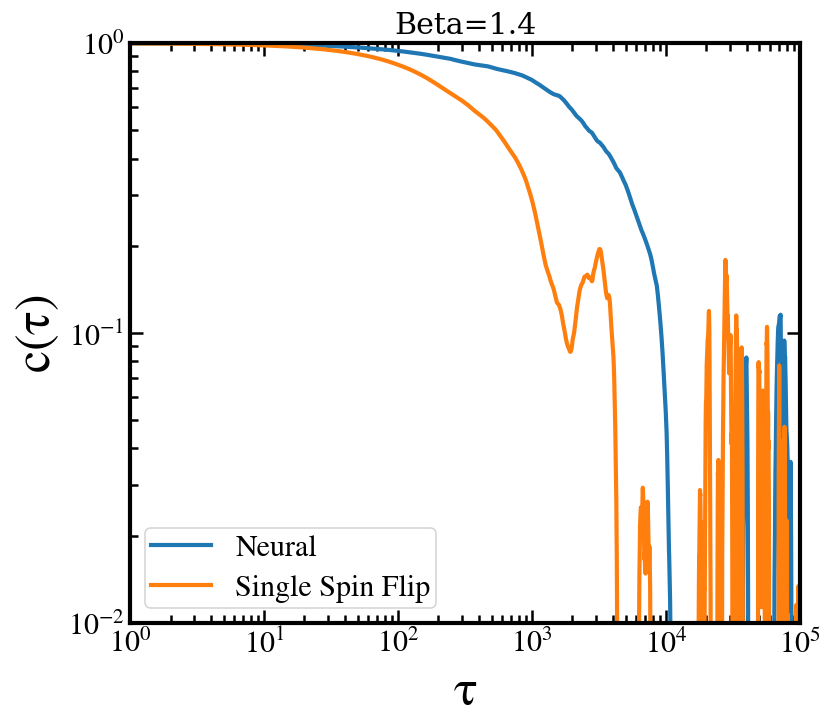

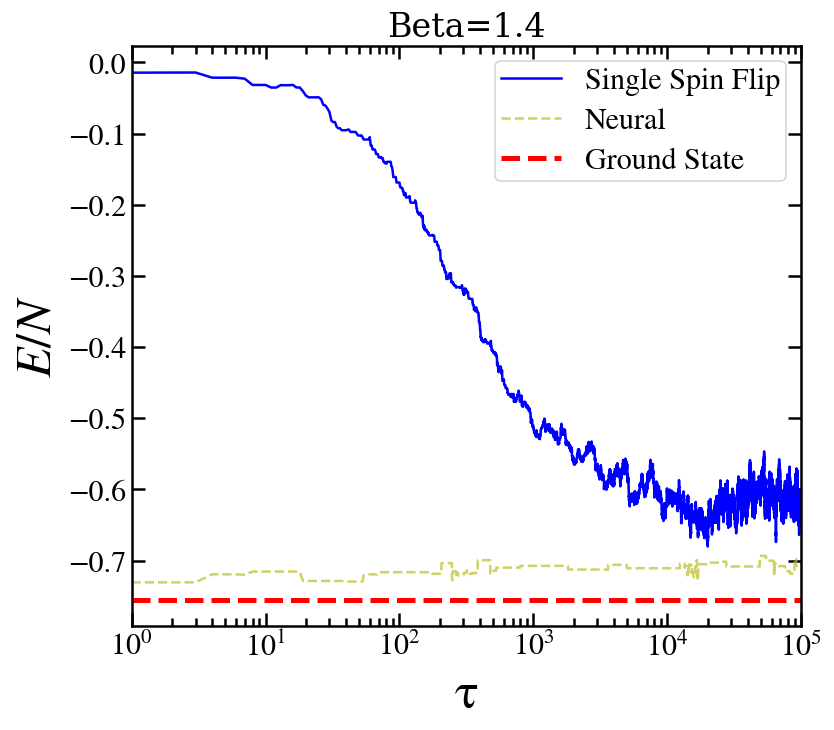


Performing Neural MCMC at beta=1.5
Steps: 100000 A_r=0.16%
E=-0.707975 ± 0.000023  [σ=0.007160  E_min=-0.736815]
Duration 0:00:03.198469


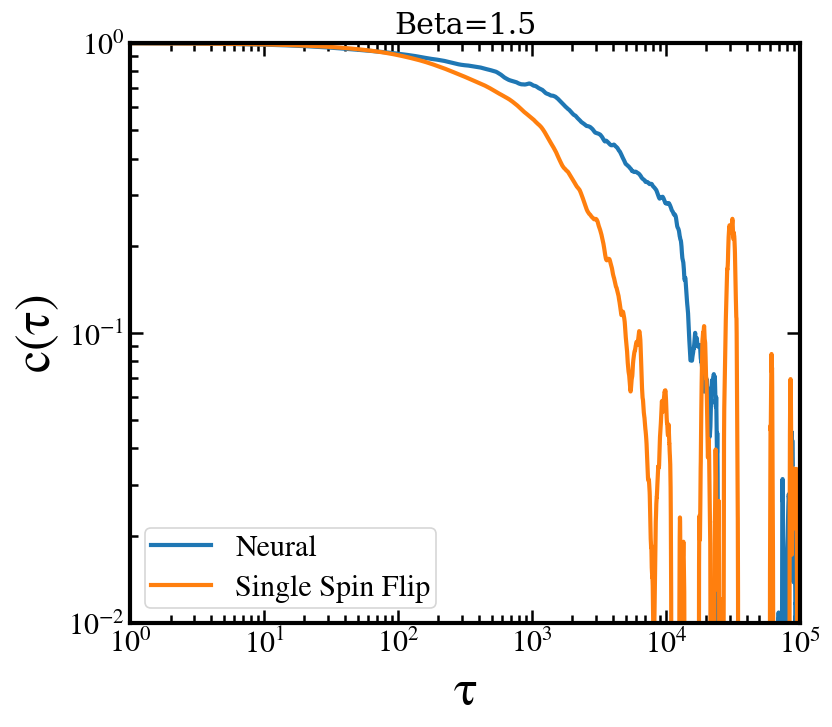

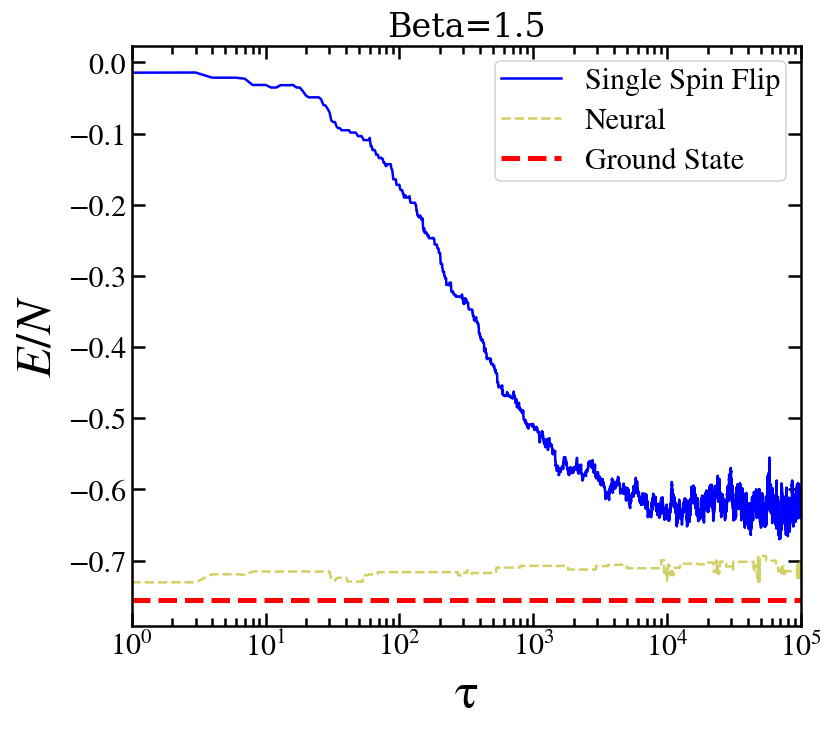


Performing Neural MCMC at beta=1.6
Steps: 100000 A_r=0.08%
E=-0.708250 ± 0.000020  [σ=0.006331  E_min=-0.736815]
Duration 0:00:02.947580


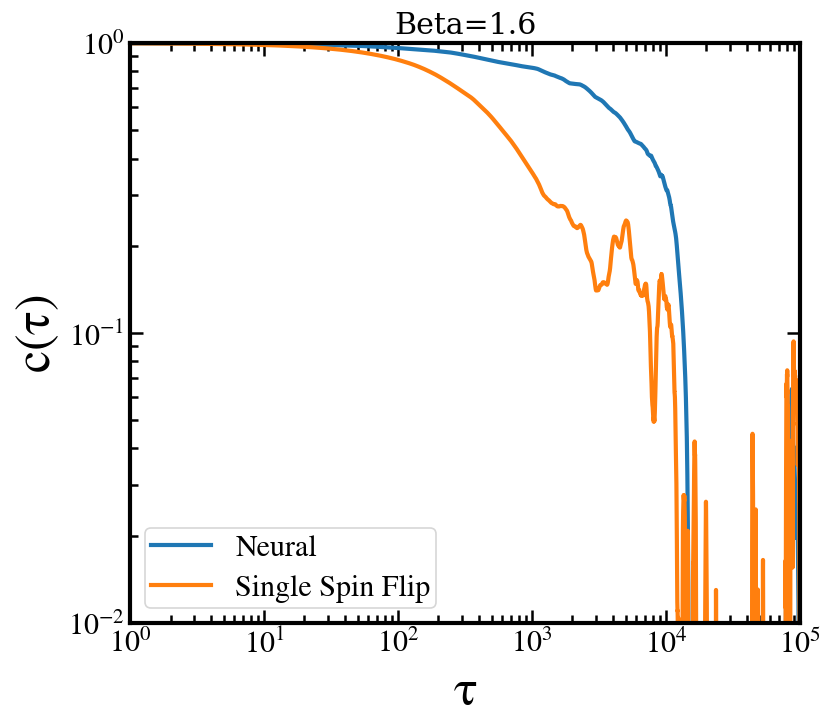

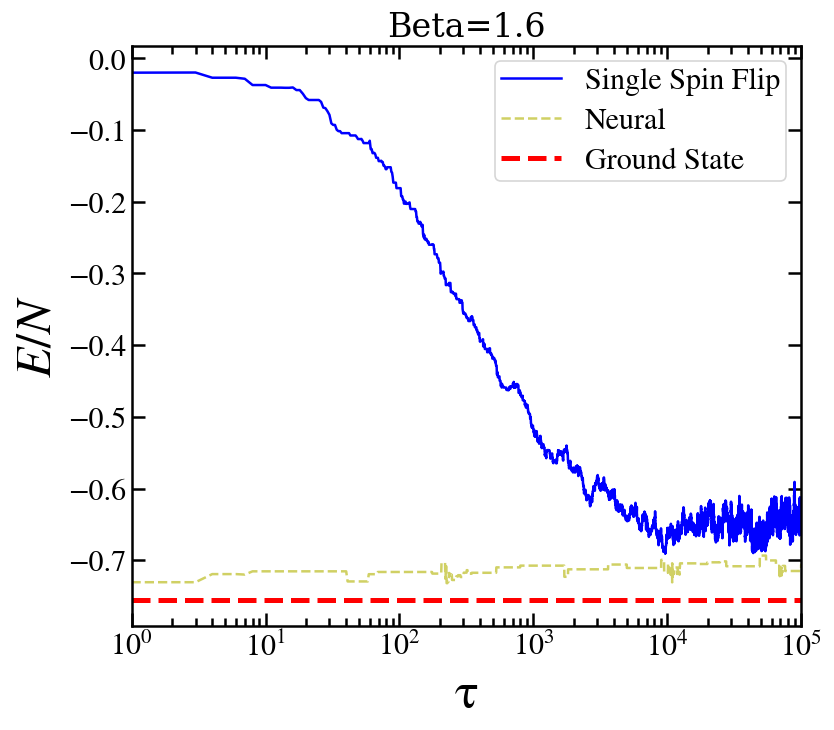


Performing Neural MCMC at beta=1.7000000000000002
Steps: 100000 A_r=0.11%
E=-0.709040 ± 0.000018  [σ=0.005630  E_min=-0.737640]
Duration 0:00:03.334031


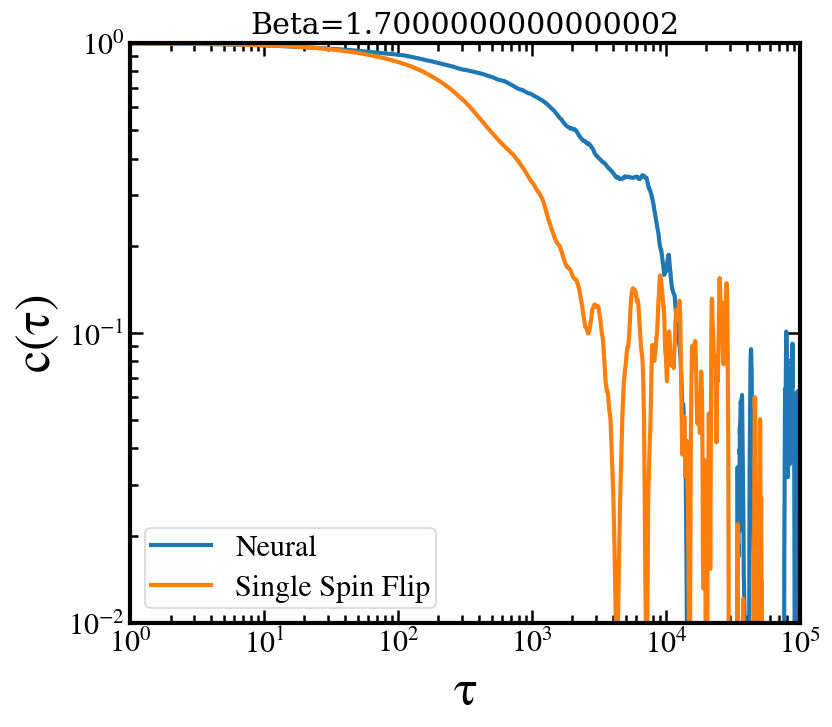

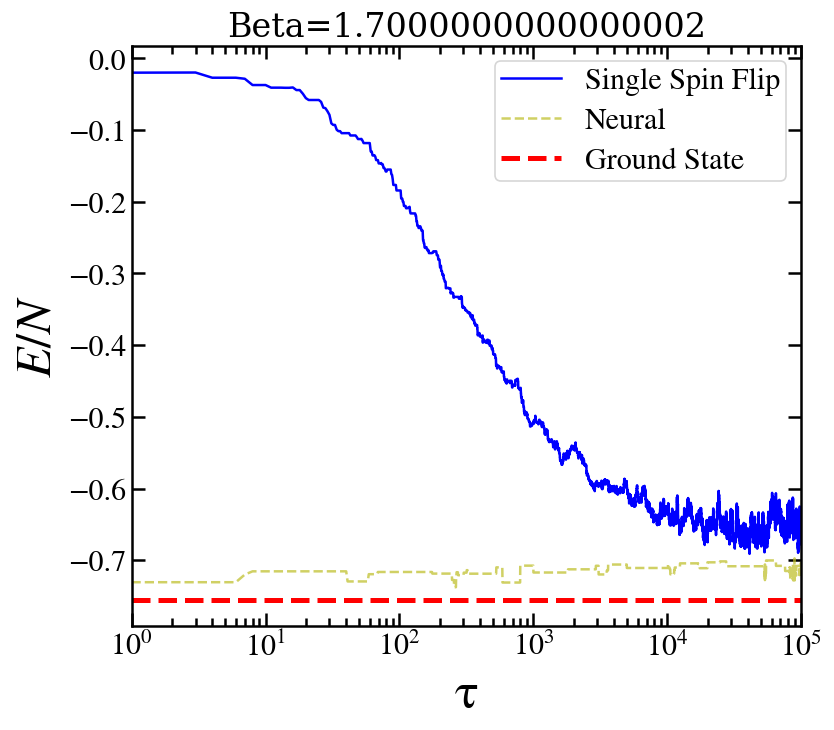


Performing Neural MCMC at beta=1.8
Steps: 100000 A_r=0.18%
E=-0.711864 ± 0.000021  [σ=0.006767  E_min=-0.738389]
Duration 0:00:03.010975


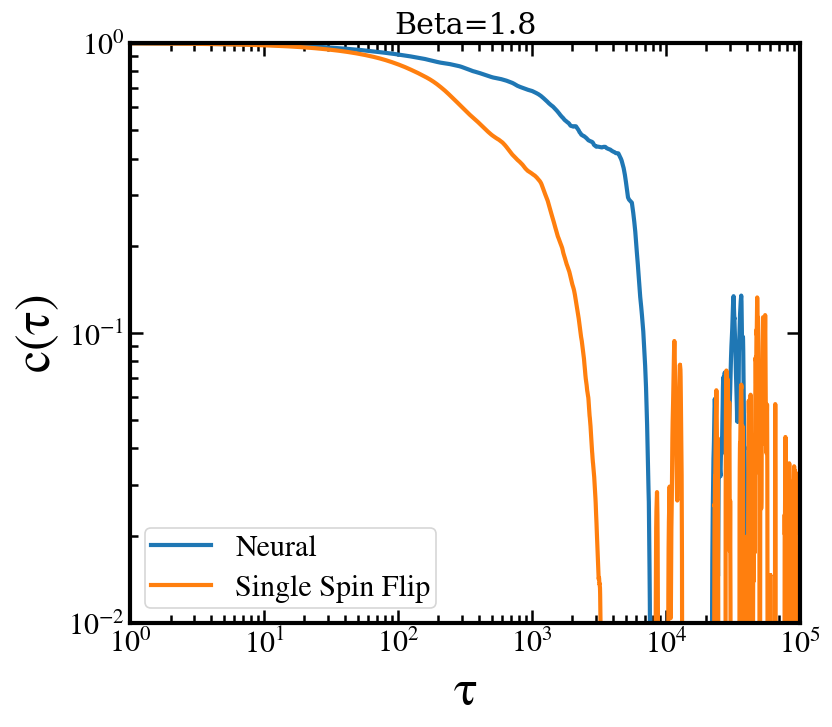

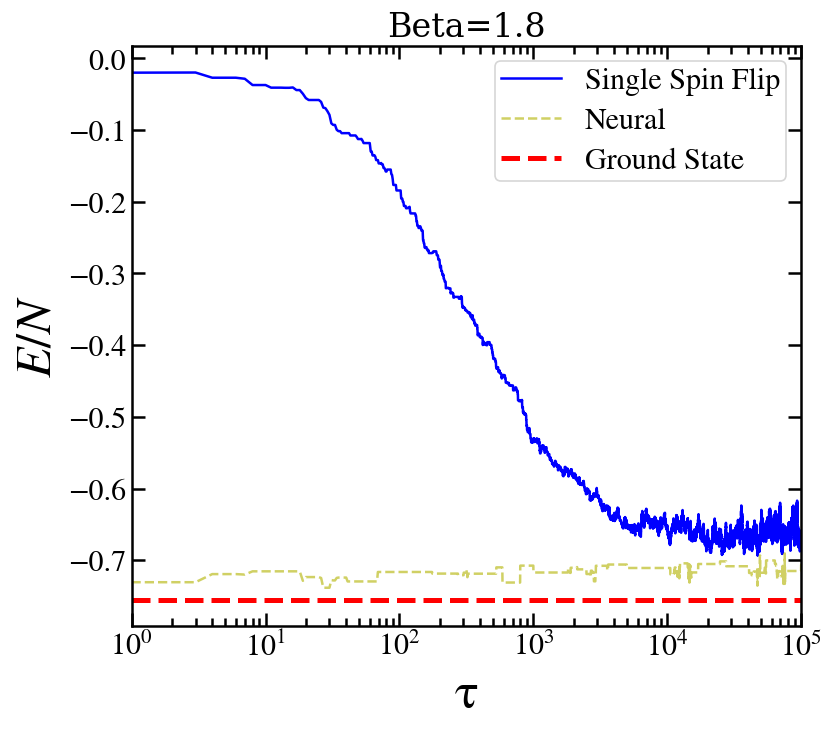


Performing Neural MCMC at beta=1.9


KeyboardInterrupt: 

In [21]:
for i, b in enumerate(betas):
    _, eng_nn, ar = neural_mcmc(b, 1000, datasets[2], couplings_path, "made", disable_bar=True)
    eng_nn = eng_nn / spins
    ac_nn = acf(eng_nn, nlags=eng_nn.shape[0], fft=True)

    plt_acf([ac_nn, ac_betas[i]], ["Neural", "Single Spin Flip"], xlim=(1, 100000), title=f"Beta={b}")
    plt_eng_step(betas_eng_single[i], eng_nn, "Single Spin Flip", "Neural", ground_state=ground_state,
        xlim=(1,100000), title=f"Beta={b}")


## Hybrid Algorithm

Here we do the same analisys for the *Hybrid MCMC*.

In [2]:
seq_hybrid = ["data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.0_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.1_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.2_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.3_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.4_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.5_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.6_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.7_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.8_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta1.9_200000hybrid-mcmc_single_len100.npz", 
              "484spins_beta2.0_100000hybrid-mcmc_single_len484.npz", #"data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.0_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.1_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.2_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.3_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.4_200000hybrid-mcmc_single_len100.npz", 
              "484spins_beta2.5_100000hybrid-mcmc_single_len484.npz", #"data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.5_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.6_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.7_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.8_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta2.9_200000hybrid-mcmc_single_len100.npz",
              "484spins_beta3.0_100000hybrid-mcmc_single_len484.npz", #"data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.0_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.1_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.2_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.3_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.4_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.5_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.6_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.7_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.8_200000hybrid-mcmc_single_len100.npz", 
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta3.9_200000hybrid-mcmc_single_len100.npz",
              "data/hybrid/seq-hybrid_100mus-betas10-25/484spins_beta4.0_200000hybrid-mcmc_single_len100.npz",
]

eng_seq_hybrid = [np.load(eng)['energy'] / 484 for eng in seq_hybrid] 

In [3]:
seeds = [12345, 23451, 34512, 45123, 51234]
betas = np.linspace(2, 3, num=3)
print(betas)

[2.  2.5 3. ]


In [4]:
eng_seq_hybrid[10].shape

(48399999,)

In [9]:
paths = []
for beta in [2.0, 2.5, 3.0]:
    #for seed in seeds:
    paths.append(f"1nn-forpaper/484spins-seed12345-sample1000000-beta{str(beta)}.npy")
single_engs = get_energy(22, paths, couplings_path)

In [10]:
single_engs = np.asarray(single_engs)
single_engs.shape

(3, 1000000)

In [11]:
skip=800000

ac_betas = []
for i in range(3):
    ac_betas.append(acf(single_engs[i,skip:], nlags=50000, fft=True))

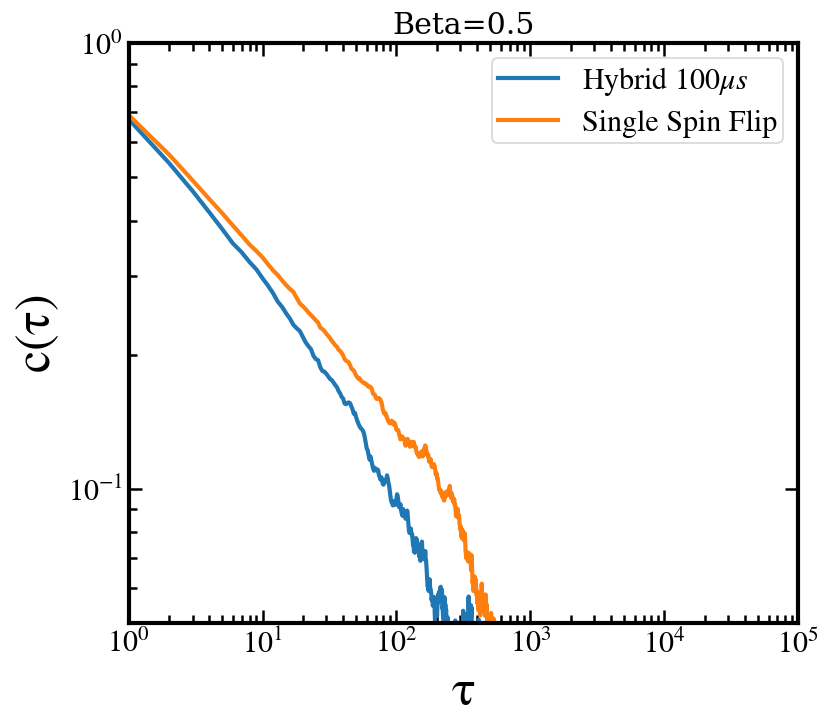

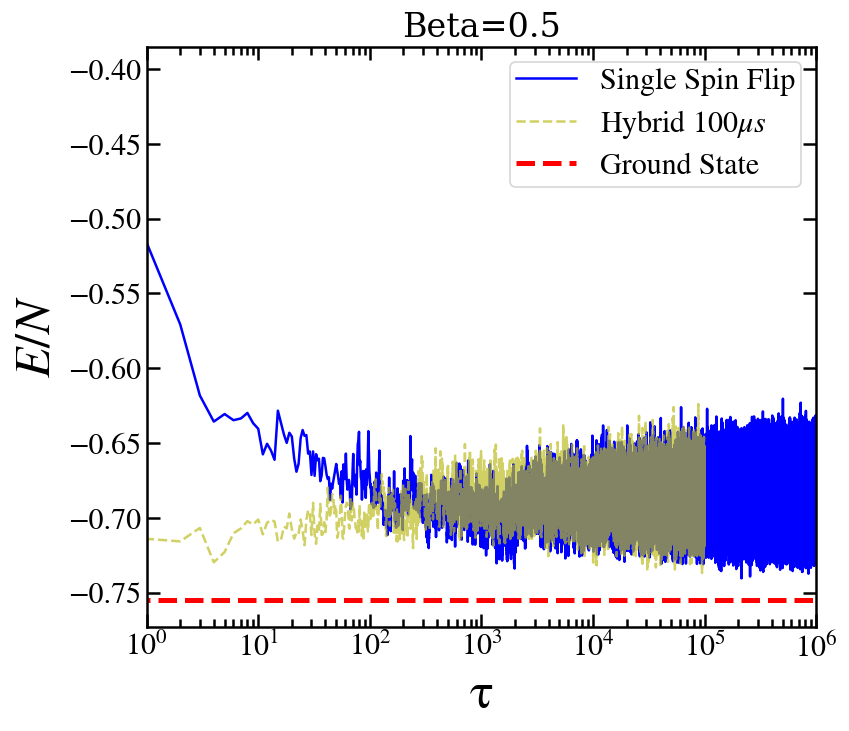

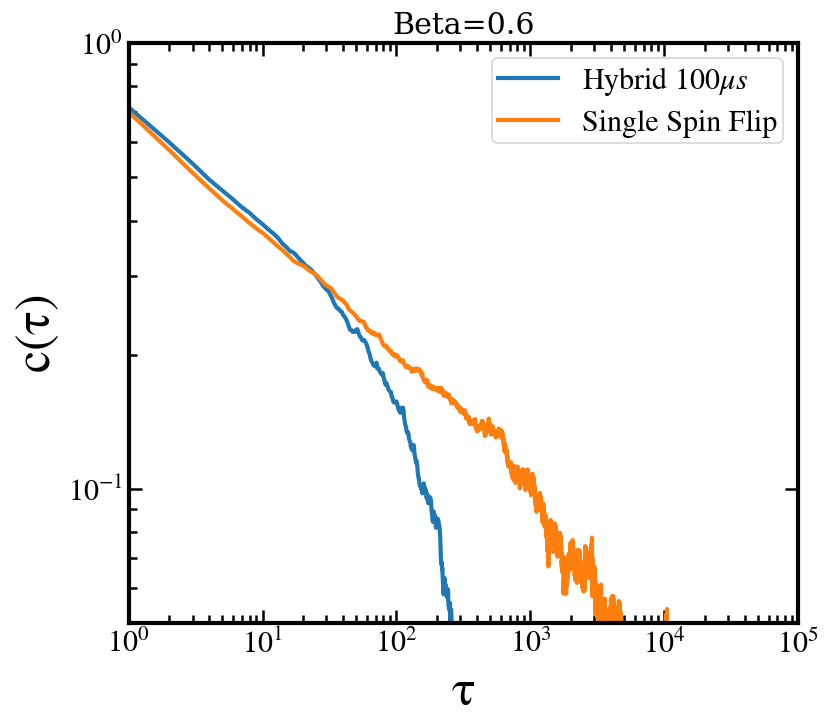

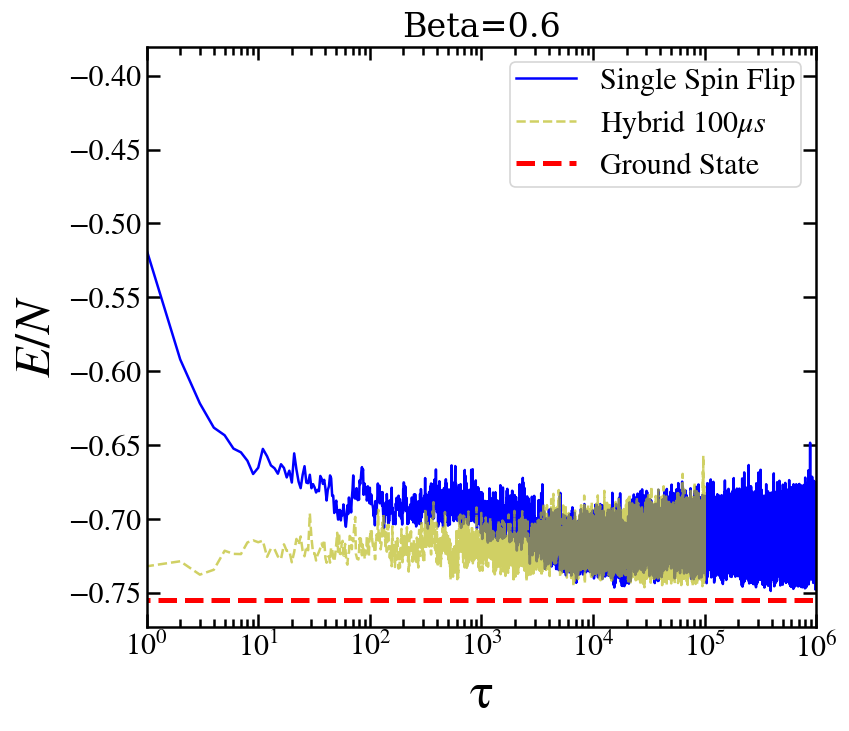

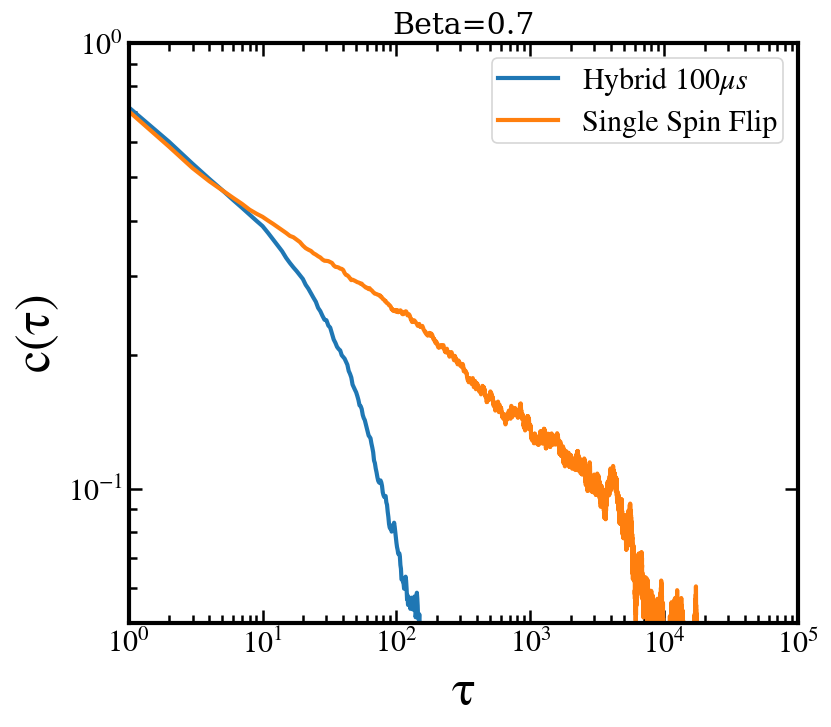

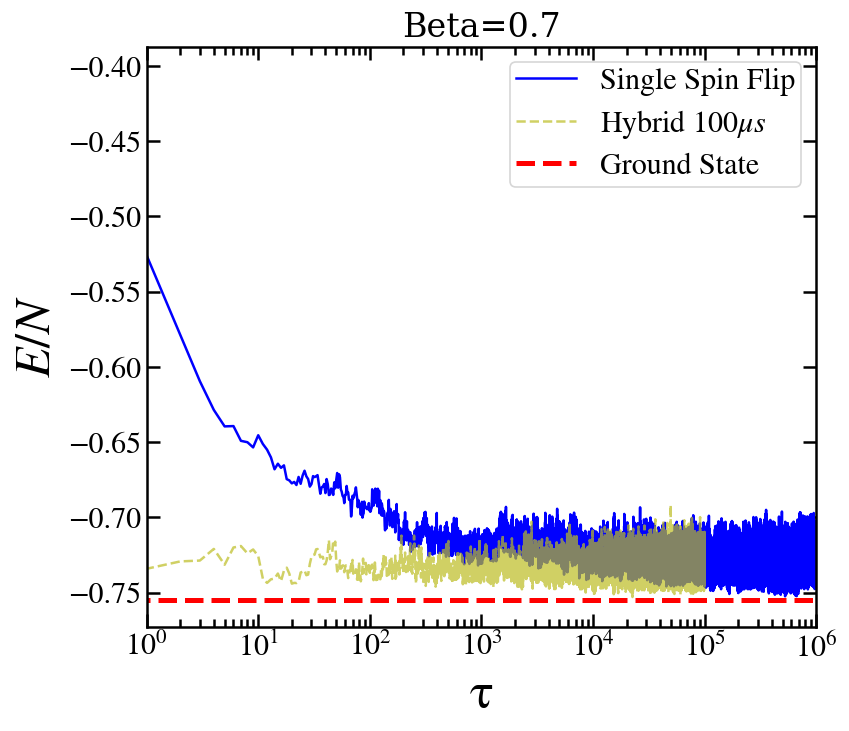

In [23]:
idxs = [10, 15, 20]

for i, idx in enumerate(idxs):
    ac_hybrid = acf(eng_seq_hybrid[idx][::484], nlags=20000, fft=True)
    plt_acf([ac_hybrid, ac_betas[i]], [r"Hybrid $100\mu s$", "Single Spin Flip"], ylim=(0.05, 1), xlim=(1, 100000), title=f"Beta={betas[i]}")
    plt_eng_step(single_engs[i,...], eng_seq_hybrid[idx][::484], "Single Spin Flip", r"Hybrid $100\mu s$", ground_state=ground_state,
        xlim=(1,1000000), title=f"Beta={betas[i]}")

## How DWave works
In the following we describe briefly how the Dwave system works. In particular, we focuse on the choice of the *chains*' strenghts, where the *chains* are the coupled qubits in the quantum annealer that represent a single varible in the original problem. Usually, the DWave sistem's topology doesn't fit exactly the original problem topology, so we need to embed our problem using a heuristic algorithm, generating this kind of *chains*.

Moreover, the annealing time is one of the most imprtant parameter to take in account. In particular low annealing time leads to a noisy solution with many high energy samples. In the following we compare sample obtain with different annealing time or different chains' stringht. Then we show how one can connect the annealing time with an effective $\beta$ in a themodinamic of the lattice. 

In [16]:
dwave_path = "data"
rnds = ["uniform", "gaussian", "binary"]
strenghts = np.linspace(0.5, 4, 15)

# uniform-couplings properties
uniform_ground_state = -0.7550297905
uniform_dwave_default = 1.5828847157168355
# gaussian-couplings properties
gaussian_ground_state = -1.2769078779999998 
gaussian_dwave_default = 2.7174204926999237
# binary-couplings properties
binary_ground_state = -1.3636342975206612
binary_dwave_default =  2.7629798143572195

In [17]:
engs = {"uniform": [], "gaussian": [], "binary": [],}
for rnd in rnds:
    for strenght in strenghts:
        try:
            eng = np.load(f"{dwave_path}/sweep_chains_{rnd}/dwave-engs_{strenght}.npy")
        except:
            pass
        engs[rnd].append(eng)
    engs[rnd] = np.asarray(engs[rnd])

In [20]:
def plt_eng_chains(engs: List[np.ndarray], ground_state: int, dwave_default: Optional[float] = None, xlim: Tuple[float, float] = (0.4, 4.1), title: Optional[str] = None, save: bool = False):
    fig, ax = plt.subplots(figsize=(7.2, 6.4), dpi=120)

    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["axes.linewidth"] = 2.5
    plt.rcParams["axes.linewidth"] = 1.5

    stringfont = "serif"

    ax.tick_params(
        axis="y",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=1.5,
        length=8,
        direction="in",
        labelsize=18,
    )
    ax.tick_params(
        axis="x",
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        width=1.5,
        length=8,
        direction="in",
        labelsize=18,
    )

    plt.plot(strenghts, engs.min(1) / 484, "-s", label=r"Minimum")
    plt.errorbar(strenghts, engs.mean(1) / 484, engs.std(1) / 484, capsize=5., elinewidth=1.5, linewidth=.1, marker='s', color='tab:orange', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Mean")

    plt.hlines(ground_state, xmin=xlim[0]-.4, xmax=xlim[1]+.4, colors='red', linestyles='dashed', label="Ground State", linewidth=3)

    if dwave_default is not None and title is not None:
        plt.plot(dwave_default, np.load(f"data/sweep_chains_{title.lower()}/dwave-engs_0.npy").min() / 484, "d", color='tab:green', label=f"DWave default")
        plt.errorbar(dwave_default, np.load(f"data/sweep_chains_{title.lower()}/dwave-engs_0.npy").mean() / 484, np.load(f"data/sweep_chains_{title.lower()}/dwave-engs_0.npy").std() / 484, elinewidth=1.5, linewidth=.1, marker='d', color='tab:green', fillstyle='none', markersize=8, markeredgewidth=2, label=f"DWave default")


    plt.xlim(xlim)

    plt.ylabel(r"$\mathrm{E}$", fontsize=30, fontfamily=stringfont, fontweight='bold')
    plt.xlabel(r"Chains Strength",  fontsize=18, fontfamily=stringfont, fontweight='bold')

    plt.title(rf"$L=22$ {title} 1 NN",  fontsize=20, fontfamily=stringfont)

    plt.legend(loc='best', fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)
    if save:
        plt.savefig("strenght-energy_uniform.png", edgecolor='white', facecolor=fig.get_facecolor(), bbox_inches='tight')

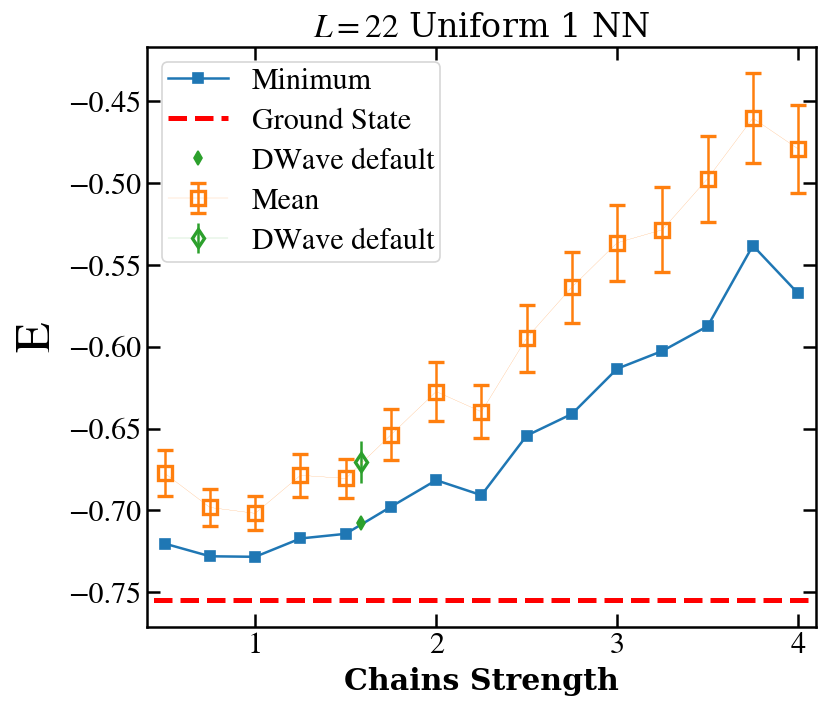

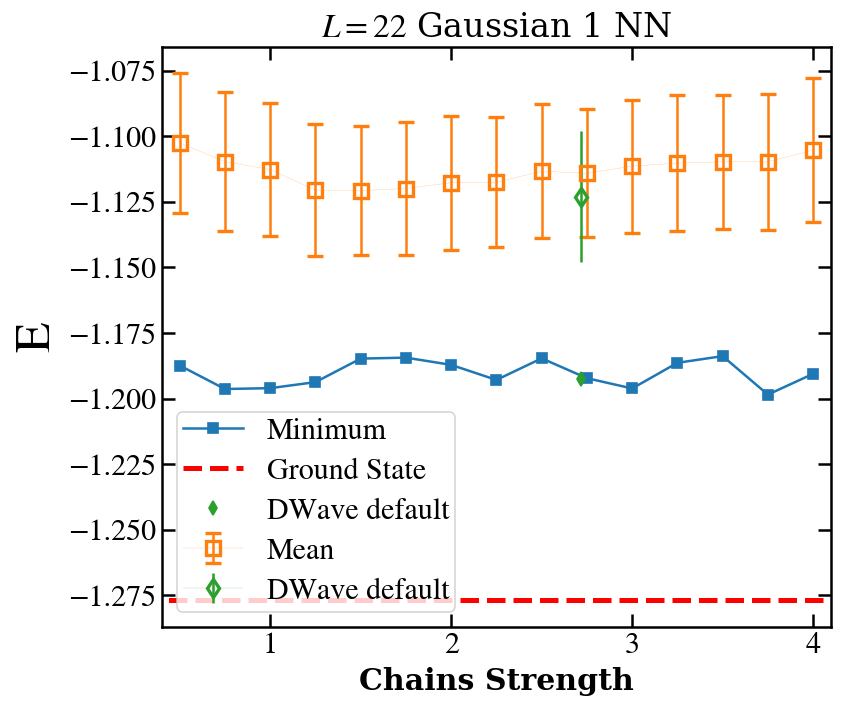

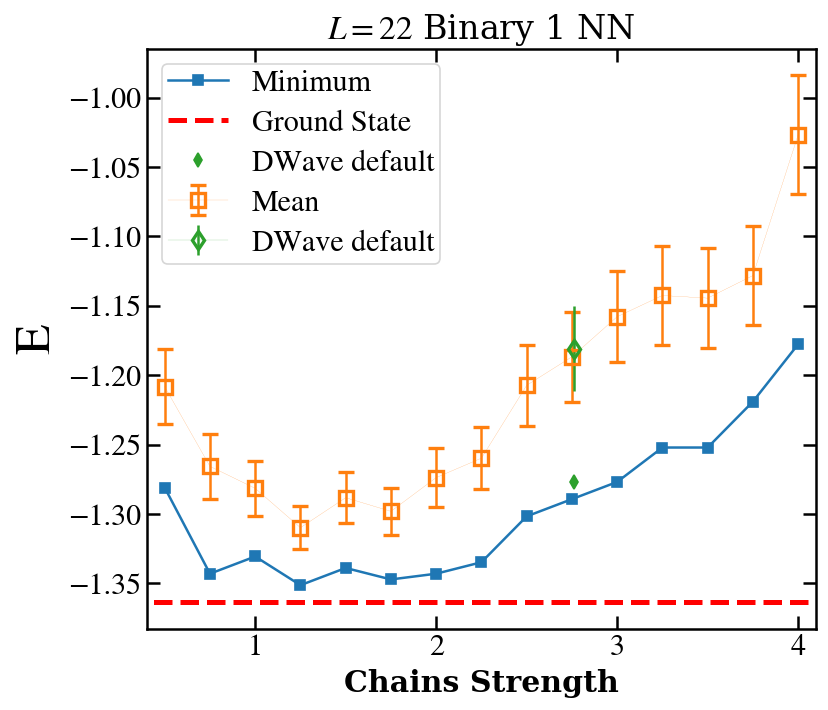

In [21]:
ground_states = [uniform_ground_state, gaussian_ground_state, binary_ground_state]
dwave_defaults = [uniform_dwave_default, gaussian_dwave_default, binary_dwave_default]
titles = ["Uniform", "Gaussian", "Binary"]

for i, rnd in enumerate(rnds):
    plt_eng_chains(engs[rnd], ground_state=ground_states[i], dwave_default=dwave_defaults[i], title=titles[i])

## Dataset a secondi vicini 3NN


In [23]:
datasets = [
        "data/generated/sample-500000_size-484_2022-03-01_11-09-49.npz", # 1mus 1nn
        "data/generated/sample-1000000_size-484_2022-03-01_11-48-11.npz", # 10mus 1nn
        "data/generated/sample-1000000_size-484_2022-03-01_11-50-00.npz", # 100mus 1nn
        #"data/generated/sample-1000000_size-484_2022-05-10_23-59-33.npz", # 1-10-100mus 1nn
        #"data/generated/sample-1000000_size-484_2022-02-10_15-28-37.npz", # 1<beta<2.5 1nn
        #"data/generated/sample-1000000_size-484_2022-02-10_17-00-33.npz" # 100mus and 1<beta<2.5 1nn
        ]

labels = [r"1 $\mu$s",r"10 $\mu$s", r"100 $\mu$s"]

betas = np.linspace(0.5,8, num=31)
print(betas)
couplings_path = "data/couplings/484spins-uniform-3nn.txt"
ground_state = -1.0982 

[0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75
 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75 7.   7.25
 7.5  7.75 8.  ]


In [24]:
acc_rates = []
for i, dataset in enumerate(datasets):
    acc_rate = []
    for beta in betas:
        _, eng_neural, ar = neural_mcmc(beta, 50000, dataset, couplings_path, "made", disable_bar=True)
        acc_rate.append(ar)
    acc_rates.append(acc_rate)


Performing Neural MCMC at beta=0.5
Steps:  50000 A_r=0.05%
E=-0.993650 ± 0.000024  [σ=0.005289  E_min=-1.054394]
Duration 0:00:01.586348

Performing Neural MCMC at beta=0.75
Steps:  50000 A_r=0.04%
E=-1.013439 ± 0.000032  [σ=0.007247  E_min=-1.054394]
Duration 0:00:01.646013

Performing Neural MCMC at beta=1.0
Steps:  50000 A_r=0.10%
E=-1.020772 ± 0.000052  [σ=0.011637  E_min=-1.069446]
Duration 0:00:01.585189

Performing Neural MCMC at beta=1.25
Steps:  50000 A_r=0.12%
E=-1.024121 ± 0.000054  [σ=0.012078  E_min=-1.070052]
Duration 0:00:01.594507

Performing Neural MCMC at beta=1.5
Steps:  50000 A_r=0.20%
E=-1.053295 ± 0.000052  [σ=0.011633  E_min=-1.083561]
Duration 0:00:01.602648

Performing Neural MCMC at beta=1.75
Steps:  50000 A_r=0.26%
E=-1.065202 ± 0.000040  [σ=0.008852  E_min=-1.085075]
Duration 0:00:01.633779

Performing Neural MCMC at beta=2.0
Steps:  50000 A_r=0.18%
E=-1.074481 ± 0.000035  [σ=0.007903  E_min=-1.087513]
Duration 0:00:01.616600

Performing Neural MCMC at beta

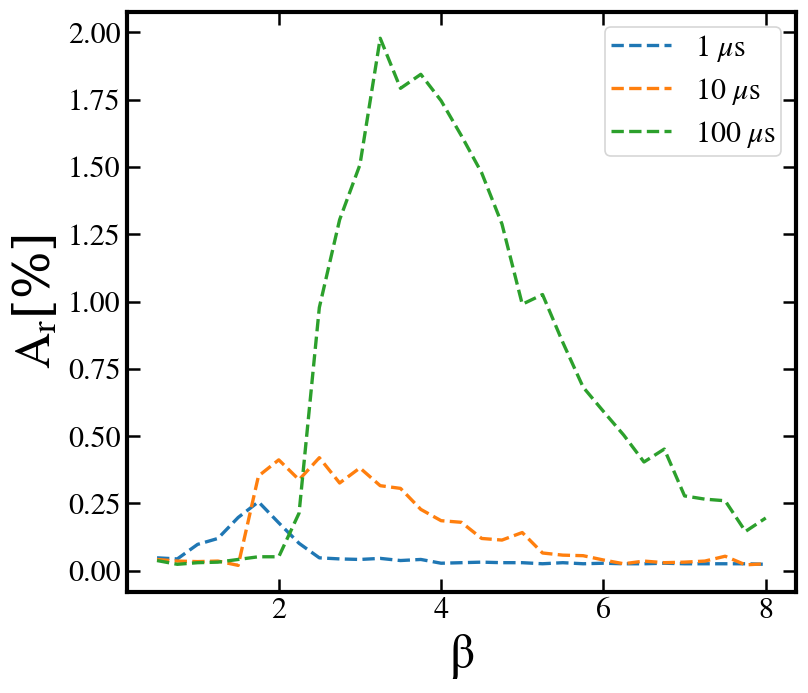

In [25]:
# remove the labels of the dataset  
# that we didn't use
labels_ar = []
for i, label in enumerate(labels): 
    labels_ar.append(label)

plt_betas_ar(acc_rates, labels_ar, betas)